## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../TCT')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
APInames_current = TCT.get_Translator_APIs()
#set(APInames_current)-set(APInames)


In [7]:
APInames

{'Automat-ctd(Trapi v1.4.0)': 'https://automat.transltr.io/ctd/1.4/query',
 'BioThings Explorer (BTE) TRAPI': 'https://bte.transltr.io/v1/query',
 'Biothings Therapeutic Target Database API': 'https://biothings.ncats.io/ttd/query',
 'Aragorn(Trapi v1.4.0)': 'https://aragorn.transltr.io/aragorn/query',
 'ARAX Translator Reasoner - TRAPI 1.4.0': 'https://arax.transltr.io/api/arax/v1.4/query',
 'RTX KG2 - TRAPI 1.4.0': 'https://arax.ncats.io/api/rtxkg2/v1.4/query',
 'SPOKE KP for TRAPI 1.4': 'https://spokekp.transltr.io/api/v1.4/query',
 'Multiomics BigGIM-DrugResponse KP API': 'https://bte.test.transltr.io/v1/smartapi/adf20dd6ff23dfe18e8e012bde686e31/query',
 'Multiomics ClinicalTrials KP': 'https://api.bte.ncats.io/v1/smartapi/d86a24f6027ffe778f84ba10a7a1861a/query',
 'Multiomics Wellness KP API': 'https://api.bte.ncats.io/v1/smartapi/02af7d098ab304e80d6f4806c3527027/query',
 'Multiomics EHR Risk KP API': 'https://api.bte.ncats.io/v1/smartapi/d86a24f6027ffe778f84ba10a7a1861a/query',
 'B

In [3]:
# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs  # This need revision because of the metaKG information changes from the SmartAPI team
#print(metaKG.columns)
#print(metaKG.shape)

In [9]:
# select the metaKG with API name starting with Multiomics
multiomics_KG = metaKG[metaKG['API'].str.contains('Multiomics')]
multiomics_KG.to_csv('../multiomics_metakg.csv', index=False)

In [3]:
# Step 2: Get metaKG and all predicates from Translator APIs
#metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs  # This need revision because of the metaKG information changes from the SmartAPI team
#print(metaKG.columns)
#print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
#All_categories

In [4]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'FLT3'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
#input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))



print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:2322
all relevant predicates in Translator:
['biolink:derives_into', 'biolink:causes', 'biolink:produced_by', 'biolink:positively_correlated_with', 'biolink:affected_by', 'biolink:has_output', 'biolink:disrupts', 'biolink:gene_product_of', 'biolink:negatively_correlated_with', 'biolink:associated_with_sensitivity_to', 'biolink:derives_from', 'biolink:response_affected_by', 'biolink:associated_with', 'biolink:is_substrate_of', 'biolink:associated_with_resistance_to', 'biolink:directly_physically_interacts_with', 'biolink:sensitivity_associated_with', 'biolink:has_gene_product', 'biolink:output_of', 'biolink:disrupted_by', 'biolink:resistance_associated_with', 'biolink:genetically_associated_with', 'biolink:related_to', 'biolink:coexists_with', 'biolink:affects', 'biolink:affects_response_to', 'biolink:decreases_response_to', 'biolink:part_of', 'biolink:binds', 'biolink:correlated_with', 'biolink:has_substrate', 'biolink:increases_response_to', 'biolink:related_to_at_instance_le

In [5]:
API_URLs

['https://automat.renci.org/pharos/1.4/query',
 'https://api.bte.ncats.io/v1/smartapi/e3edd325c76f2992a111b43a907a4870/query',
 'https://bte.test.transltr.io/v1/smartapi/adf20dd6ff23dfe18e8e012bde686e31/query',
 'https://api.bte.ncats.io/v1/smartapi/38e9e5169a72aee3659c9ddba956790d/query',
 'https://ars-prod.transltr.io/ara-robokop/api/runquery',
 'https://automat.ci.transltr.io/ctd/1.4/query',
 'https://api.bte.ncats.io/v1/8f08d1446e0bb9c2b323713ce83e2bd3/query',
 'https://api.bte.ncats.io/v1/smartapi/1d288b3a3caf75d541ffaae3aab386c8/query',
 'https://translator.broadinstitute.org/molepro/trapi/v1.4/query',
 'https://automat.renci.org/icees-kg/1.4/query',
 'https://api.bte.ncats.io/v1/smartapi/978fe380a147a8641caf72320862697b/query',
 'https://automat.renci.org/gtopdb/1.4/query',
 'https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query',
 'https://automat.ci.transltr.io/cam-kp/1.4/query?limit=100',
 'https://biothings.ncats.io/ttd/query',
 'https://api.bte.ncats.io/v1/smar

In [6]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


Warning Code:404:https://api.bte.ncats.io/v1/8f08d1446e0bb9c2b323713ce83e2bd3/query
Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
Warning Code:404:https://ars-prod.transltr.io/ara-robokop/api/runquery
Warning Code:405:https://automat.ci.transltr.io/hetio/1.4/query
Warning Code:405:https://automat.ci.transltr.io/ctd/1.4/query
Warning Code:405:https://automat.ci.transltr.io/cam-kp/1.4/query?limit=100
Warning Code:400:https://biothings.ncats.io/ttd/query
Success!https://automat.transltr.io/ctd/1.4/query
Warning Code:405:https://automat.renci.org/hmdb/1.4/query
Warning Code:405:https://automat.renci.org/pharos/1.4/query
Warning Code:405:https://automat.renci.org/gtopdb/1.4/query
Warning Code:405:https://automat.renci.org/icees-kg/1.4/query
Success!https://api.bte.ncats.io/v1/smartapi/edeb26858bd27d0322af93e7a9e08761/query
Success!https://translator.broadinstitute.org/molepro/trapi/v1.4/query
Success!https://bte.test.transltr.io/v1/smartapi/adf20dd6ff23

In [7]:
print(query_json)

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2322'], 'categories': ['biolink:Gene']}, 'n1': {'categories': ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:derives_into', 'biolink:causes', 'biolink:produced_by', 'biolink:positively_correlated_with', 'biolink:affected_by', 'biolink:has_output', 'biolink:disrupts', 'biolink:gene_product_of', 'biolink:negatively_correlated_with', 'biolink:associated_with_sensitivity_to', 'biolink:derives_from', 'biolink:response_affected_by', 'biolink:associated_with', 'biolink:is_substrate_of', 'biolink:associated_with_resistance_to', 'biolink:directly_physically_interacts_with', 'biolink:sensitivity_associated_with', 'biolink:has_gene_product', 'biolink:output_of', 'biolink:disrupted_by', 'biolink:resistance_associated_with', 'biolink:genetically_associated_with', 'biolink:related_to', 'biolink:coexists_with', 'biolink:affects', 'biolink

DRUGBANK:DB12182: no preferred name
NodeNorm does not know about these identifiers: PUBCHEM.COMPOUND:11610113,INCHIKEY:PCIMPOMGHFNGMS-JPIWIFTLSA-N,CHEBI:226199,CHEBI:205064,CHEBI:204813,INCHIKEY:VMUAYDSPKYLLJV-UHFFFAOYSA-N,TTD.DRUG:D0Q8CV,TTD.DRUG:D0YQ9I,TTD.DRUG:DI1VM3,TTD.DRUG:DIA08F,TTD.DRUG:D04GFO,TTD.DRUG:D07ZNF,TTD.DRUG:D0AK1F,TTD.DRUG:D0V2ZC,TTD.DRUG:D0X8ID,TTD.DRUG:D91CMX,TTD.DRUG:D0D1HS,TTD.DRUG:D0MX7B,CHEMBL.COMPOUND:CHEMBL5314406,CHEMBL.COMPOUND:CHEMBL5314391,CHEMBL.COMPOUND:CHEMBL5314390,MESH:D000393,CHEBI:207278,CHEBI:219687,INCHIKEY:DPFYPHSPTUZJJT-KYSSRYLCSA-N,INCHIKEY:QZIANMAYEYYSQX-SELCFAFUSA-N,INCHIKEY:PTRVZEMPNWFZEI-PCXKSQOTSA-N,INCHIKEY:KVUCOURZIKDXHZ-HCZCYALWSA-N,INCHIKEY:CPNQAVXQGZKRMM-SELCFAFUSA-N,INCHIKEY:AHZDWGRDNJBCPX-SELCFAFUSA-N,INCHIKEY:ZFBBKOBKYNRTOS-SAWYFRRKSA-N,INCHIKEY:MIYIUVBGBPRNLG-SELCFAFUSA-N,INCHIKEY:MXNSTJDJNSFMJJ-RAKDUWMASA-N,INCHIKEY:QDCNDOVOAIZYTL-SAWYFRRKSA-N,INCHIKEY:PPEONOSSNNKMMB-PCXKSQOTSA-N,INCHIKEY:KMDUVZLDXOHFPQ-DNAVMEGLSA-N,INCHIKEY:BPF

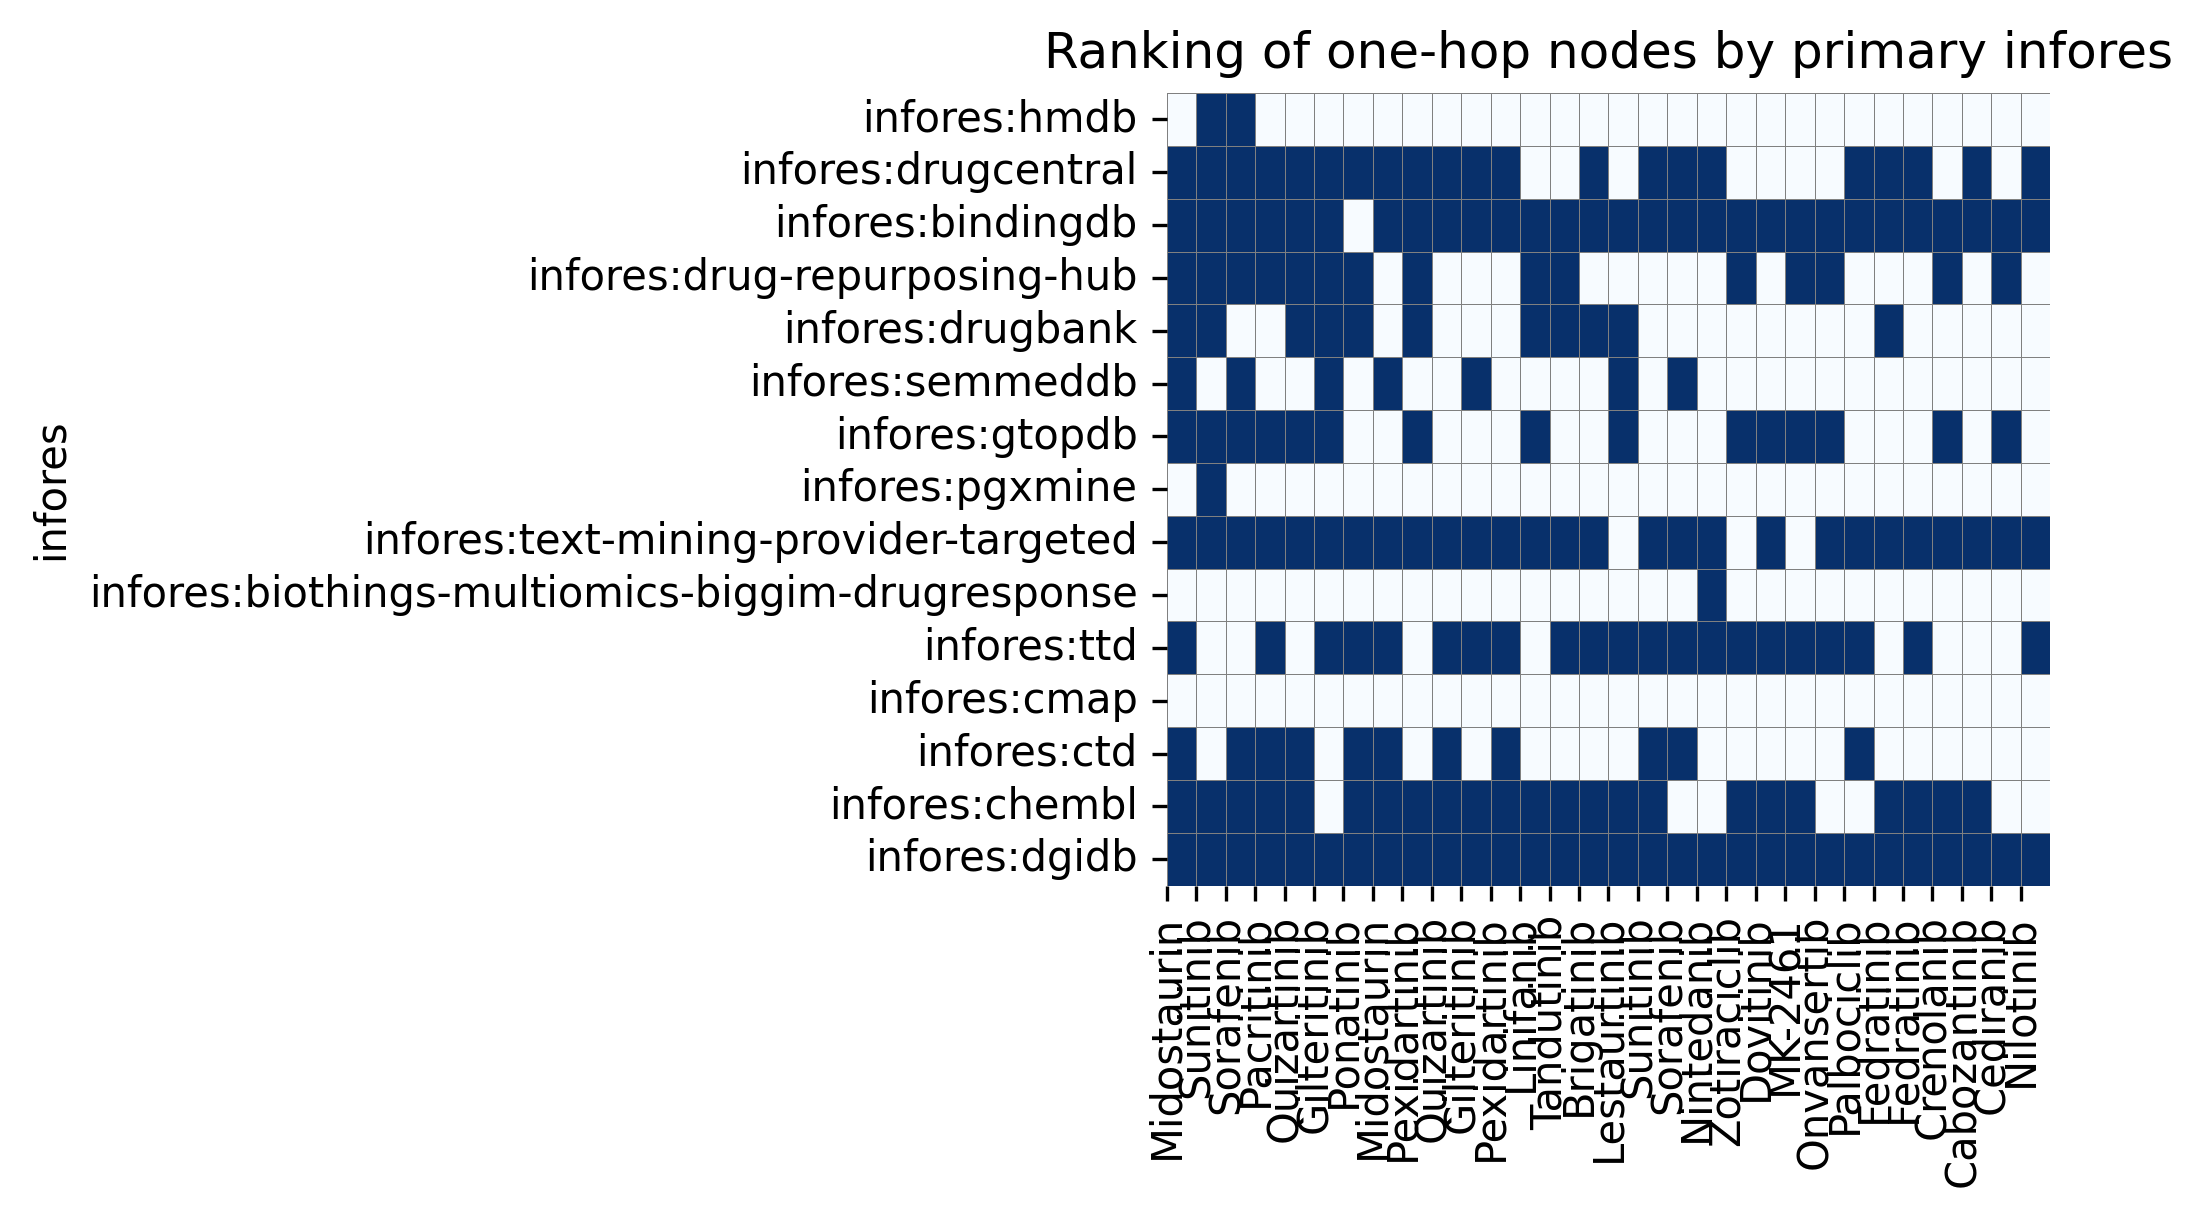

[Text(0.5, 0, 'Midostaurin'), Text(2.5, 0, 'Sorafenib'), Text(4.5, 0, 'Quizartinib'), Text(6.5, 0, 'Ponatinib'), Text(8.5, 0, 'Pexidartinib'), Text(10.5, 0, 'Gilteritinib'), Text(12.5, 0, 'Linifanib'), Text(14.5, 0, 'Brigatinib'), Text(16.5, 0, 'Sunitinib'), Text(18.5, 0, 'Nintedanib'), Text(20.5, 0, 'Dovitinib'), Text(22.5, 0, 'Onvansertib'), Text(24.5, 0, 'Fedratinib'), Text(26.5, 0, 'Crenolanib'), Text(28.5, 0, 'Cediranib')]


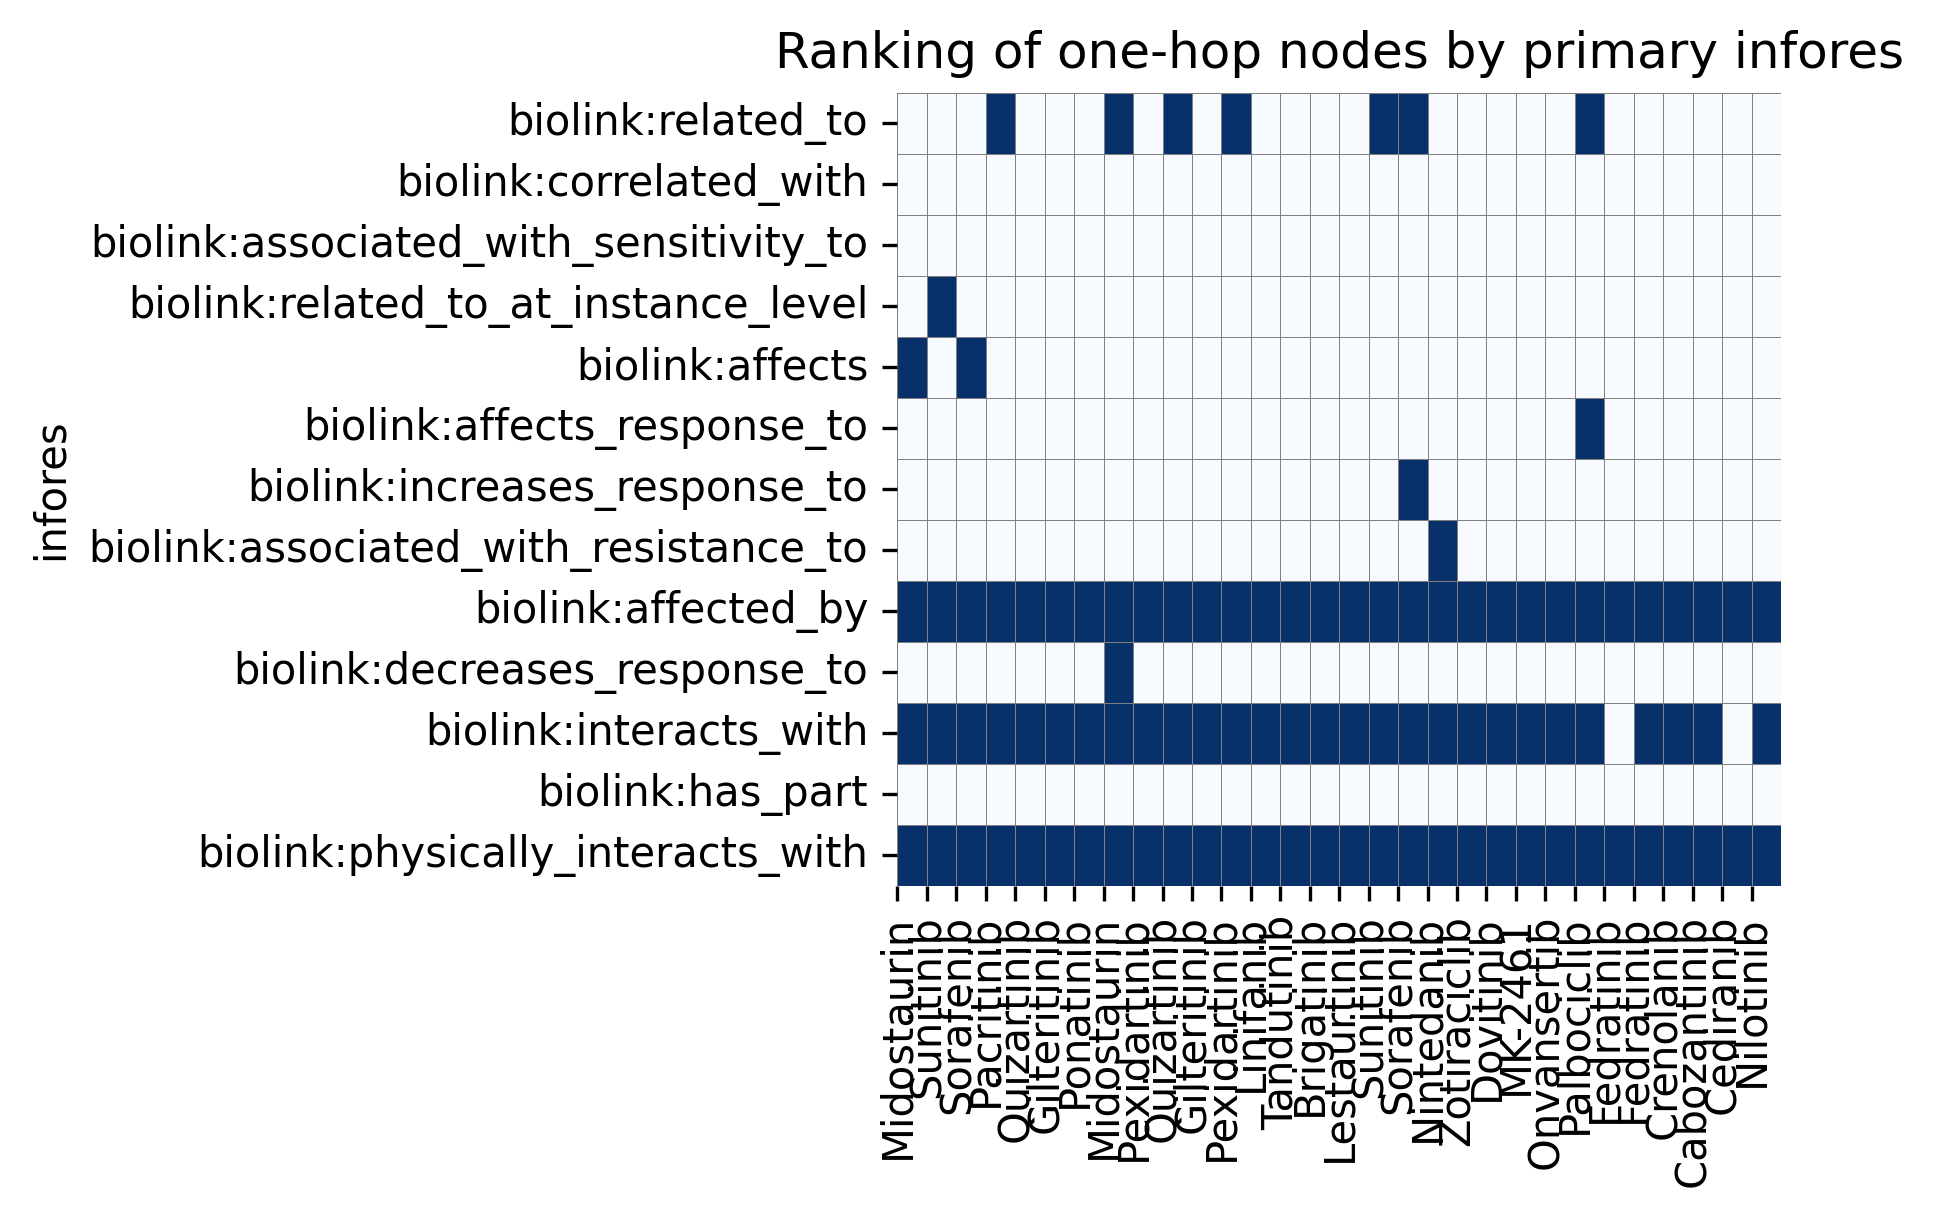

,Midostaurin,Sunitinib,Sorafenib,Pacritinib,Quizartinib,Gilteritinib,Ponatinib,Midostaurin,Pexidartinib,Quizartinib,...,"1-(3-chlorophenyl)-N-[6-[8-(2-morpholin-4-ylethylamino)imidazo[1,2-a]pyrazin-3-yl]pyridin-2-yl]propane-1,3-diamine",INCHIKEY:KEDANNMRCOENMZ-LLJCYPMUSA-N,"6,7-Bis(3-hydroxyphenyl)pteridine-2,4-diamine","2-{4-[(1Z)-1-(hydroxyimino)-2,3-dihydro-1H-inden-5-yl]-3-(pyridin-4-yl)-1H-pyrazol-1-yl}ethan-1-ol","3-((4-Bromo-2,6-difluorobenzyl)oxy)-5-(3-(4-(pyrrolidin-1-yl)butyl)ureido)isothiazole-4-carboxamide",Eriodictyol,"US10689362, Example 28","US10689362, Example 39","US10689362, Example 40","N-(5-(((5-(1,1-Dimethylethyl)-2-oxazolyl)methyl)thio)-2-thiazolyl)-4-piperidinecarboxamide"
biolink:related_to,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
biolink:correlated_with,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_sensitivity_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:related_to_at_instance_level,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:affects,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:affects_response_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:increases_response_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_resistance_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:affected_by,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:decreases_response_to,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 30, input_query = input_node1_id, 
                                fontsize = 6)


In [9]:
# End of the example